In [1]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine, text
import pymc as pm
import arviz as az
from scipy.stats import zscore

# Define the SQLalchemy engine
engine = create_engine(f"sqlite:////Users/JO/PhD/neuro-ascertainment/data/db.sqlite")

# Read the SQL query from the file
with open('/Users/JO/PhD/neuro-ascertainment/candidate-queries/transferred-nsicu-cohort/transferred-cohort.sql', 'r') as file:
    query = file.read()

SEED = 20
rng = np.random.default_rng(SEED)

def count_id(df):
    LopNr = df['LopNr'].nunique() if 'LopNr' in df else 'Column missing'
    VtfId_LopNr = df['VtfId_LopNr'].nunique() if 'VtfId_LopNr' in df else 'Column missing'
    HADM_ID = df['HADM_ID'].nunique() if 'HADM_ID' in df else 'Column missing'
    return print(f'Unique patients: {LopNr} | Unique SIR admits: {VtfId_LopNr} | Unique PAR admits: {HADM_ID}')

### PAR_HADM
This is the PAR table with an identifer ID for each admission.

In [2]:
query_PAR_HADM = query + "SELECT * FROM PAR_HADM"
PAR_HADM = pd.read_sql(query_PAR_HADM, engine)
count_id(PAR_HADM)

Unique patients: 59333 | Unique SIR admits: Column missing | Unique PAR admits: 359305


### PR_ICU_ADMISSIONS
"Primary ICU admissions". SIR admissions in ICUs at a hospital without NSICU capacity (i.e. mainly primary (länsdelssjukhus) and secondary (länssjukhus) hospitals).

In [3]:
query_PR_ICU_ADMISSIONS = query + "SELECT * FROM PR_ICU_ADMISSIONS"
PR_ICU_ADMISSIONS = pd.read_sql(query_PR_ICU_ADMISSIONS, engine)
count_id(PR_ICU_ADMISSIONS)

Unique patients: 26518 | Unique SIR admits: 28822 | Unique PAR admits: Column missing


### PR_ICU_ADMISSIONS_MATCHED_WITH_PAR
Primary ICU admissions matched with PAR admissions at university hospitals (any department, any dx) +/- 1 day of primary ICU discharge.

In [4]:
query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR"
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR = pd.read_sql(query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR, engine)
count_id(PR_ICU_ADMISSIONS_MATCHED_WITH_PAR)

Unique patients: 8206 | Unique SIR admits: 8381 | Unique PAR admits: 8841


In [5]:
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR.head(3)

,VtfId_LopNr,HADM_ID,LopNr,InskrTidPunkt,UtskrTidPunkt,AvdNamn,INDATUM,UTDATUM,MVO,SJUKHUS
0,175633.0,186729,33694.0,1610590020,1610648400,STGIVA,18641,18668,331,11003
1,175640.0,203729,36615.0,1610658000,1610673300,SU/IVA-INF,18641,18642,121,51001
2,175646.0,276169,49700.0,1610711100,1610721000,Västerås,18642,18654,331,12001


### PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX
Adds inferred diagnostic group to the PR_ICU_ADMISSIONS_MATCHED_WITH_PAR table for each PAR admission.

In [6]:
query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX"
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = pd.read_sql(query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX, engine)
count_id(PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX)

Unique patients: 8206 | Unique SIR admits: 8381 | Unique PAR admits: 8841


### PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY
Ranks matched PAR admissions for each primary ICU admissions in terms of "relevance". First, the PAR admissions (if there are more than one) are ranked based on admission date (earlier = higher rank). Ties are resolved by a diagnostic hierarchy. 

In [7]:
query_TIME_HIERARCHY= query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY"
TIME_HIERARCHY  = pd.read_sql(query_TIME_HIERARCHY, engine)
count_id(TIME_HIERARCHY)

Unique patients: 7292 | Unique SIR admits: 7434 | Unique PAR admits: 7721


### SUMMARY_TABLE and SUMMARY_TABLE_FIRST
These tables add columns from PAR, DORS and SIR describing demographics and ICU admission status from the tables DESCRIPTIVE_PAR and DESCRIPTIVE_SIR. All rows with a PAR DX != ranked (based on time + dx hierarchy) as 1 are discharged.

In SUMMARY_TABLE some "helper columns" are added to help with guessing the most relevant ICU admission for the transfer. Most patients have a Primary ICU admission and a PAR admission. But there are cases where patients are readmitted to the primary ICU in the days around the PAR admit. Also, in some cases patients are transferred between primary ICU's. The helper columns are:
* rows_per_patient, keeps count of the number of entries per patient in the SUMMARY_TABLE. Helps with keeping track of patients that need further tie breakers.
* earliest_par_admit_date, finds the earliest matched PAR admit date for the patient. Helps defining the "first ICU admission event", for example in the case where the patient is admitted in 2019 with an ASAH and in 2020 with HC.
* par_admit_relative_sir_dsc, this is the difference in days between tertiary PAR admit and primary ICU discharge. Can be -1, 0, 1. (eg. 1 = Admitted to PAR the (calendar) day after PR ICU admission.)
* icu_admit_rank, grouped on patient ID (LopNr) the par_admit_relative_sir_dsc is used to rank pairs of PRICU-PAR admissions. par_admit_relative_sir_dsc = 0 (same day) gets the highest rank, followed by par_admit_relative_sir_dsc = 1 (PAR admission day after a PRICU discharge) and -1 (PAR admission day before a PRICU discharge). This will help guessing the most relevant ICU admission for the transfer in case of readmissions et cetera. If tied (eg. two admissions on the transfer day) the PR ICU admit with the latest discharge time (hrs:min) will be ranked higher.

In the SUMMARY_TABLE_FIRST table, only the PRICU-PAR pairs matching the earliest_par_admit_date are selected. Finally the highest ranking PRICU-PAR pair based on icu_admit_rank is choosen for each patient. Note that this does not come with any *guarantees* about correct PRICU-PAR pairings, but it's my best *guess*. There are some missclassified patients, for example a case where a patient is transferred from Bollnäs (discharged day 0) -> Gävle (discharged day 1) -> Uppsala (admitted day 0). Here the ranking mechanism will infer that the transfer is from Bollnäs -> Uppsala. However, handling this correctly would mean introduction of new concepts (such as a hierarchical ranking of primary ICUs) which will further increase complexity to handle a few edge cases.

In [8]:
query_DESC_PAR = query + "SELECT * FROM SUMMARY_TABLE_FIRST"
DESC = pd.read_sql(query_DESC_PAR, engine)

# format time
DESC['par_adm_date'] = pd.to_datetime(DESC['par_adm_date'], unit='D')
DESC['par_dsc_date'] = pd.to_datetime(DESC['par_dsc_date'], unit='D')
DESC['earliest_par_admit_date'] = pd.to_datetime(DESC['earliest_par_admit_date'], unit='D')

DESC['sir_adm_time'] = pd.to_datetime(DESC['sir_adm_time'], unit='s')
DESC['sir_dsc_time'] = pd.to_datetime(DESC['sir_dsc_time'], unit='s')
DESC['sir_adm_year'] = DESC['sir_adm_time'].dt.year

count_id(DESC)

Unique patients: 7292 | Unique SIR admits: 7292 | Unique PAR admits: 7292


In [9]:
#Let's take a look a slightly controversial group: the patients discharged from a primary ICU on day 0 and admitted to a tertiary center on day -1.

In [10]:
DESC[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].query("par_admit_relative_sir_dsc == -1").iloc[120:160]

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date
4129,37069.0,2018-03-18 03:00:00,2018-03-18 04:30:00,2018-03-17,2018-03-18,SU/IVA-ÖS,Sahlgrenska universitetssjukhuset,TBI,1,-1,2018-03-17
4131,37091.0,2011-07-16 15:16:00,2011-07-17 14:35:00,2011-07-16,2011-07-16,NU Trollhättan,Sahlgrenska universitetssjukhuset,ABM,1,-1,2011-07-16
4139,37142.0,2019-06-30 16:30:00,2019-07-01 15:25:00,2019-06-30,2019-07-02,SU/IVA-MS,Sahlgrenska universitetssjukhuset,SEP,2,-1,2019-06-30
4154,37252.0,2021-10-13 19:15:00,2021-10-14 16:00:00,2021-10-13,2021-10-22,SU/IVA-INF,Sahlgrenska universitetssjukhuset,ABM,1,-1,2021-10-13
4236,37838.0,2018-01-05 22:15:00,2018-01-06 01:00:00,2018-01-05,2018-01-18,IVAUSÖ,Akademiska sjukhuset,ASAH,1,-1,2018-01-05
4364,38617.0,2021-02-24 21:00:00,2021-02-25 01:00:00,2021-02-24,2021-03-03,Sundsvall IVA,Norrlands universitetssjukhus,ICH,1,-1,2021-02-24
4397,38854.0,2020-10-11 02:30:00,2020-10-11 05:00:00,2020-10-10,2020-10-15,Östersund,Norrlands universitetssjukhus,SDH,1,-1,2020-10-10
4464,39280.0,2012-11-23 00:44:00,2012-11-23 10:12:00,2012-11-22,2012-11-23,SU/IVA-ÖS,Sahlgrenska universitetssjukhuset,TBI,1,-1,2012-11-22
4519,39764.0,2013-01-11 21:30:00,2013-01-12 00:40:00,2013-01-11,2013-01-29,IVA Hudiksvall,Akademiska sjukhuset,ASAH,1,-1,2013-01-11
4533,39953.0,2018-07-20 14:17:00,2018-07-21 01:38:00,2018-07-20,2018-07-22,SÖSIVA,"Karolinska universitetssjukhuset, Solna",ABM,1,-1,2018-07-20


Looking at 80 of these transfers (>200 in total) around 12 look suspicious: these could be transfers going in the other direction (eg. a patient going directly from the primary (or tertiary) EMERGENCY DEPT -> Tertiary ICU -> Primary ICU and discharged from the primary ICU early). Luckily, most of these are "short distance transfers" (SÖS->KS, Östra->Sahlgrenska) with 1-2 exceptions. The vast majority of longer transfers seem relevant as they stay in the tertiary center for several days. 

An interesting observation is that most obviously relevant pairs have PR ICU discharges typically between 12 pm and 3 am, which makes sense. This is in contrast with the suspicious pars where the ICU discharge is typically in the afternoon (which also makes sense if the patient travelled in the direction Tertiary center -> PR ICU -> discharged from PR ICU). In order to decrease the number of false positive transfers, adding the condition of dsc between 00:00 and 04:00 will help.

It's also worth noting that in the cases where the patient has their tertiary PAR admit the day after the PR ICU discharge, the PR ICU discharge time is almost always in >10 pm which makes perfect sense.

In [11]:
query_DESC_pruned = query + "SELECT * FROM SUMMARY_TABLE_FIRST_PRUNE_LATE"
DESC_pruned = pd.read_sql(query_DESC_pruned, engine)

# format time
DESC_pruned['par_adm_date'] = pd.to_datetime(DESC_pruned['par_adm_date'], unit='D')
DESC_pruned['par_dsc_date'] = pd.to_datetime(DESC_pruned['par_dsc_date'], unit='D')
DESC_pruned['earliest_par_admit_date'] = pd.to_datetime(DESC_pruned['earliest_par_admit_date'], unit='D')

DESC_pruned['sir_adm_time'] = pd.to_datetime(DESC_pruned['sir_adm_time'], unit='s')
DESC_pruned['sir_dsc_time'] = pd.to_datetime(DESC_pruned['sir_dsc_time'], unit='s')
DESC_pruned['sir_adm_year'] = DESC_pruned['sir_adm_time'].dt.year

count_id(DESC_pruned)

Unique patients: 7181 | Unique SIR admits: 7181 | Unique PAR admits: 7181


This is the result of the pruned table looking a patients with par_admit_relative_sir_dsc = -1:

In [12]:
DESC_pruned[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].query("par_admit_relative_sir_dsc == -1").head(40)

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date
7067,695.0,2016-04-06 17:15:00,2016-04-07 00:45:00,2016-04-06,2016-04-08,Eskilstuna,Akademiska sjukhuset,TBI,1,-1,2016-04-06
7068,722.0,2020-05-24 21:00:00,2020-05-25 00:40:00,2020-05-24,2020-06-02,Eskilstuna,Akademiska sjukhuset,ICH,1,-1,2020-05-24
7069,729.0,2020-10-05 22:50:00,2020-10-06 00:05:00,2020-10-05,2020-10-13,IVA Falun,Akademiska sjukhuset,ICH,1,-1,2020-10-05
7070,874.0,2021-03-13 18:00:00,2021-03-14 00:40:00,2021-03-13,2021-03-16,Västerås,Akademiska sjukhuset,TBI,1,-1,2021-03-13
7071,1175.0,2017-04-30 19:40:00,2017-05-01 00:15:00,2017-04-30,2017-05-06,Bollnäs,Akademiska sjukhuset,TBI,1,-1,2017-04-30
7072,1409.0,2019-03-11 13:45:00,2019-03-12 01:00:00,2019-03-11,2019-03-15,Kalmar,Universitetssjukhuset i Linköping,TBI,1,-1,2019-03-11
7073,2929.0,2011-07-31 20:50:00,2011-08-01 00:58:00,2011-07-31,2011-08-01,SU/IVA-ÖS,Sahlgrenska universitetssjukhuset,TBI,1,-1,2011-07-31
7074,3446.0,2016-01-18 20:20:00,2016-01-19 00:01:00,2016-01-18,2016-01-28,Varberg,Sahlgrenska universitetssjukhuset,ASAH,1,-1,2016-01-18
7075,3558.0,2016-05-03 20:00:00,2016-05-04 01:30:00,2016-05-03,2016-05-15,Varberg,Sahlgrenska universitetssjukhuset,ICH,1,-1,2016-05-03
7076,4567.0,2012-05-13 20:45:00,2012-05-14 01:00:00,2012-05-13,2012-06-01,Sundsvall IVA,Norrlands universitetssjukhus,ICH,1,-1,2012-05-13


Looks ok! Now for a quick summary of the patients:

In [13]:
s = DESC_pruned.groupby('DX_GROUP').agg({'age': 'mean', 'sex_female': 'mean', 'sir_total_time': 'median', 'SAPS_GCS': 'median', 'any_AMV': 'mean', 'd30': 'mean', 'VtfId_LopNr': 'count'})
s.rename(columns={'VtfId_LopNr': 'n'}).sort_values(by='n', ascending=False)

,age,sex_female,sir_total_time,SAPS_GCS,any_AMV,d30,n
DX_GROUP,,,,,,,
TBI,57.288745,0.267989,180.0,12.0,0.607011,0.126845,2168
ASAH,58.954186,0.629525,110.0,12.0,0.470588,0.163462,1768
ICH,58.462490,0.403712,135.0,10.0,0.650425,0.204176,1293
AIS,64.077961,0.344828,110.0,13.0,0.406297,0.262369,667
SDH,67.852868,0.281796,162.0,11.0,0.376559,0.104738,401
ABM,54.933908,0.442529,340.0,11.0,0.678161,0.112069,348
CFX,57.673835,0.229391,442.0,15.0,0.254480,0.071685,279
TUM,49.347826,0.380435,142.5,8.0,0.467391,0.152174,92
HC,54.645833,0.416667,182.5,9.0,0.541667,0.020833,48


And a comparison with a Venn diagram vs. the old query.

In [14]:
with open('/Users/JO/PhD/neurocritical-transfers/notes/final-analysis/0-database-query/primary-based-transfer-query.sql', 'r') as file:
    old_query = file.read()
OLD_DESC = pd.read_sql(old_query, engine)

OLD_DESC['par_adm_date'] = pd.to_datetime(OLD_DESC['par_adm_date'], unit='D')
OLD_DESC['par_dsc_date'] = pd.to_datetime(OLD_DESC['par_dsc_date'], unit='D')
OLD_DESC['sir_adm_time'] = pd.to_datetime(OLD_DESC['sir_adm_time'], unit='s').dt.normalize()


In [15]:
count_id(OLD_DESC)

Unique patients: 7219 | Unique SIR admits: 7219 | Unique PAR admits: 7219


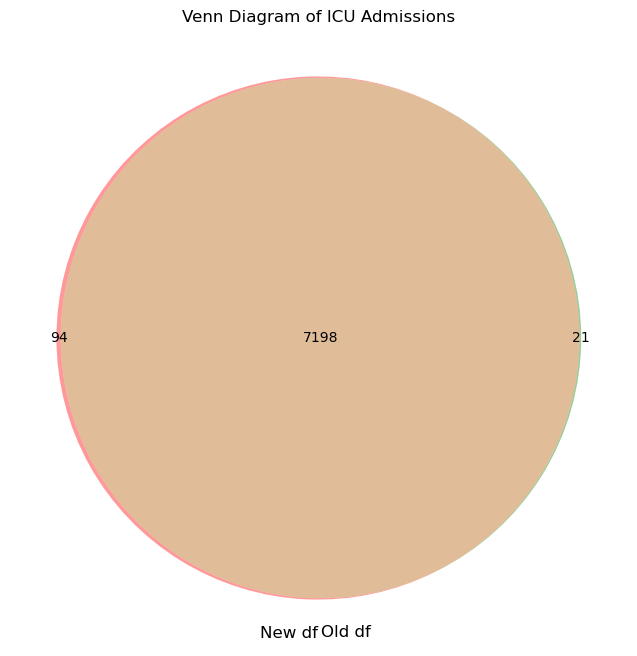

In [16]:
from matplotlib_venn import venn2

# Extract the unique IDs
set1 = set(DESC['VtfId_LopNr'])
set2 = set(OLD_DESC['VtfId_LopNr'])

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2([set1, set2], ('New df', 'Old df'))
plt.title('Venn Diagram of ICU Admissions')
plt.show()

Small differences, and most "new" cases seem reasonable.

In [17]:
exclusive_to_new = set1 - set2
exclusive_to_old = set2 - set1

In [18]:
exclusive_new = DESC[DESC['VtfId_LopNr'].isin(exclusive_to_new)]

In [19]:
exclusive_new[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].head(40)

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date
44,495.0,2016-12-08 05:30:00,2016-12-08 08:40:00,2016-12-08,2016-12-09,SU/IVA-MS,Sahlgrenska universitetssjukhuset,TUM,1,0,2016-12-08
129,1370.0,2014-10-03 13:15:00,2014-10-03 23:59:00,2014-10-03,2014-10-07,Karlstad-IVA,Sahlgrenska universitetssjukhuset,HC,1,0,2014-10-03
231,2285.0,2010-09-25 15:00:00,2010-09-25 18:30:00,2010-09-26,2010-10-15,IVA Kristianstad,Universitetssjukhuset i Lund,TBI,1,1,2010-09-26
321,3110.0,2013-07-18 10:45:00,2013-07-18 13:00:00,2013-07-18,2013-07-29,Helsingborg,Universitetssjukhuset i Lund,TBI,1,0,2013-07-18
336,3262.0,2020-07-21 13:00:00,2020-07-22 06:00:00,2020-07-21,2020-07-26,SU/IVA-INF,Sahlgrenska universitetssjukhuset,ABM,1,-1,2020-07-21
450,4264.0,2012-06-03 23:59:00,2012-06-04 02:40:00,2012-06-04,2012-06-20,Karlstad-IVA,Akademiska sjukhuset,ASAH,2,0,2012-06-04
524,4716.0,2018-07-05 10:26:00,2018-07-05 20:50:00,2018-07-06,2018-07-13,SÖS Med IVA,"Karolinska universitetssjukhuset, Solna",ICH,1,1,2018-07-06
647,5597.0,2016-05-27 15:30:00,2016-05-27 19:15:00,2016-05-27,2016-06-06,Karlstad-NOIVA,Akademiska sjukhuset,AIS,2,0,2016-05-27
688,5881.0,2020-03-18 04:15:00,2020-03-18 08:00:00,2020-03-18,2020-03-18,IVA Hudiksvall,Akademiska sjukhuset,AIS,2,0,2020-03-18
713,6109.0,2016-06-06 22:05:00,2016-06-07 01:00:00,2016-06-07,2016-06-17,Kungälv,Sahlgrenska universitetssjukhuset,TBI,1,0,2016-06-07


Checking vs Bollnäs IVA local registry:

In [20]:
DESC_pruned[['sir_adm_year','sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'any_AMV', 'd30']].query("sir_icu_name == 'Bollnäs'").query("sir_adm_year == 2017").sort_values(by='sir_adm_time')

,sir_adm_year,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,any_AMV,d30
7071,2017,2017-04-30 19:40:00,2017-05-01 00:15:00,2017-04-30,2017-05-06,Bollnäs,Akademiska sjukhuset,TBI,1,0
2788,2017,2017-05-18 22:30:00,2017-05-19 10:10:00,2017-05-19,2017-05-31,Bollnäs,Akademiska sjukhuset,ICH,1,0
5563,2017,2017-06-13 21:15:00,2017-06-13 22:35:00,2017-06-14,2017-06-22,Bollnäs,Akademiska sjukhuset,ASAH,0,0
4895,2017,2017-06-16 09:15:00,2017-06-16 11:30:00,2017-06-16,2017-06-21,Bollnäs,Akademiska sjukhuset,AIS,0,0
2769,2017,2017-07-20 01:15:00,2017-07-20 03:15:00,2017-07-20,2017-07-24,Bollnäs,Akademiska sjukhuset,SDH,1,0
6491,2017,2017-07-28 16:00:00,2017-07-28 23:20:00,2017-07-29,2017-08-02,Bollnäs,Universitetssjukhuset i Linköping,ASAH,0,0
6896,2017,2017-08-11 04:45:00,2017-08-11 05:55:00,2017-08-11,2017-08-22,Bollnäs,Akademiska sjukhuset,ASAH,0,0
6928,2017,2017-11-03 08:10:00,2017-11-03 10:00:00,2017-11-03,2017-11-04,Bollnäs,Akademiska sjukhuset,ICH,0,1
6011,2017,2017-12-27 17:45:00,2017-12-27 20:31:00,2017-12-27,2018-01-09,Bollnäs,Akademiska sjukhuset,ASAH,0,0


* 2022 (up to may): Finds 3/3 + 1 relevant AIS (intubated).
* 2021: 7/7 + 1 relevant AIS.
* 2020: 8/10 , + 2 relevant AIS. The 2 missing are not in our dataset, i.e. not a problem with the query.
* 2019: 11/11, + 3 relevant AIS.
* 2018: 3/3, + 2 relevant AIS + 2 relevant others.
* 2017: 8/8, + 1 relevant ICH.

SUM: Finds 40/42 + 12 extra patients.
 